In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Set a nice style for the plots
sns.set_theme(style="whitegrid")
print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
import os

def get_figures_path():
    target_suffix = os.path.join("Contrastive_Learning", "code", "ML_model", "figures")
    cwd = os.path.abspath(os.getcwd())
    parts = cwd.split(os.sep)
    for i in range(len(parts), 0, -1):
        candidate = os.sep.join(parts[:i])
        test_path = os.path.join(candidate, target_suffix)
        if os.path.isdir(test_path):
            return test_path
    raise FileNotFoundError(f"Path ending with '{target_suffix}' not found")


# --- Logit transformation function ---
def logit(p: pd.Series) -> pd.Series:
    """Converts PSI (0-100) to logit."""
    # Convert from 0-100 scale to 0-1 probability
    # This check is now done in get_delta_psi
    # p = p / 100.0 
    
    # Clip for numerical stability to avoid log(0) or log(1)
    p = p.clip(1e-6, 1.0 - 1e-6)
    return np.log(p / (1 - p))

# --- REVISED: Calculates delta-logit from wide PSI DataFrames ---
# --- REVISED AGAIN: Calculates delta-logit, handles column names robustly ---
def get_delta_psi(df: pd.DataFrame, tissue_cols: list, gt_df_full: pd.DataFrame) -> (pd.DataFrame, list):
    """
    Calculates delta-logit for a given wide DataFrame 'df' (predictions or GT)
    by aligning with the logit_mean_psi from the full ground truth 'gt_df_full'.
    Handles potential column name conflicts during merge.
    """
    # Ensure exon_id is present
    if 'exon_id' not in df.columns:
        raise ValueError("Input DataFrame 'df' must contain 'exon_id' column.")
    if 'exon_id' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'exon_id' column.")
    if 'logit_mean_psi' not in gt_df_full.columns:
         raise ValueError("Ground truth DataFrame 'gt_df_full' must contain 'logit_mean_psi' column.")

    # Select only the necessary columns from ground truth for the merge
    gt_subset_for_merge = gt_df_full[['exon_id', 'logit_mean_psi']].copy()

    # Define potential suffixes
    # Use distinct suffixes to clearly identify the origin after merge
    suffix_original = '_original_df' # Suffix if df already had logit_mean_psi
    suffix_from_gt = '_from_gt_df'   # Suffix for the column brought in from gt_subset_for_merge

    # Perform the merge
    merged_df = pd.merge(
        df,
        gt_subset_for_merge,
        on='exon_id',
        how='left',
        suffixes=(suffix_original, suffix_from_gt)
    )

    # --- Determine the correct ground truth logit_mean_psi column name ---
    gt_logit_mean_col = 'logit_mean_psi' # Default if no conflict occurred
    if f'logit_mean_psi{suffix_from_gt}' in merged_df.columns:
        # Conflict occurred, use the suffixed name from the ground truth
        gt_logit_mean_col = f'logit_mean_psi{suffix_from_gt}'
    elif 'logit_mean_psi' in merged_df.columns:
        # No conflict, the column from gt_subset_for_merge kept its original name
         pass # gt_logit_mean_col is already 'logit_mean_psi'
    else:
        # This shouldn't happen if the merge succeeded, but good to check
        raise KeyError("Could not find the 'logit_mean_psi' column after merging.")

    # Handle cases where predictions are for exons not in gt_df
    if merged_df[gt_logit_mean_col].isnull().any():
        missing_count = merged_df[gt_logit_mean_col].isnull().sum()
        print(f"Warning: Found {missing_count} exons in input 'df' not found in ground truth. They will be dropped.")
        merged_df = merged_df.dropna(subset=[gt_logit_mean_col])
        if merged_df.empty:
             raise ValueError("After merging and dropping missing ground truth, the DataFrame is empty.")

    # Convert only the specified tissue columns to numeric
    psi_df = merged_df[tissue_cols].apply(pd.to_numeric, errors='coerce')

    # Detect if PSI values are given as percentages (> 1.5)
    # Added check for empty DataFrame to prevent error on .max()
    if not psi_df.empty and (psi_df.max(skipna=True).max(skipna=True) > 1.5):
        print("Detected PSI values > 1.5, converting from 0-100 scale.")
        psi_df = psi_df / 100.0
    elif psi_df.empty:
         print("Warning: No valid PSI values found to process after filtering/conversion.")
         # Return an empty DataFrame structure if no data left
         empty_delta_logit = pd.DataFrame(columns=['exon_id'] + tissue_cols)
         return empty_delta_logit, tissue_cols


    # Compute logit(PSI) for each tissue
    logit_psi_df = psi_df.apply(logit)

    # Subtract the correctly identified ground truth logit_mean_psi
    delta_logit_df = logit_psi_df.sub(merged_df[gt_logit_mean_col], axis=0)

    # Add the exon_id column back
    delta_logit_df['exon_id'] = merged_df['exon_id']

    # Ensure exon_id is the first column for consistency
    delta_logit_df = delta_logit_df[['exon_id'] + tissue_cols]

    return delta_logit_df, tissue_cols


In [3]:
# --- Loads and processes the ground truth PSI file ---
def load_ground_truth(filepath: str) -> (pd.DataFrame, list):
    """
    Loads the ground truth PSI CSV file and returns the
    wide DataFrame and the list of tissue columns.
    """
    print(f"Loading and processing Ground Truth from: {filepath}")
    df = pd.read_csv(filepath)
    
    # This column indexing is from your script
    meta_cols = [
        'exon_id', 'cassette_exon', 'alternative_splice_site_group', 'linked_exons',
        'mutually_exclusive_exons', 'exon_strand', 'exon_length', 'gene_type',
        'gene_id', 'gene_symbol', 'exon_location', 'exon_boundary',
        'chromosome', 'mean_psi', 'logit_mean_psi', 'chromosome.1'
    ]
    tissue_cols = [col for col in df.columns if col not in meta_cols]

    return df, list(tissue_cols)

# --- MODIFIED: Loads SOTA *predictions* ---
def load_sota_predictions(filepath: str) -> pd.DataFrame:
    """
    Loads SOTA delta-logit predictions (which are already delta-logit)
    and returns a long-format DataFrame.
    """
    print(f"Loading SOTA predictions from: {filepath}")
    
    file_extension = Path(filepath).suffix.lower()
    separator = '\t' if file_extension == '.tsv' else ','
        
    df = pd.read_csv(filepath, sep=separator)
    
    # Melt to long format
    melted_df = df.melt(
        id_vars=['exon_id'],
        var_name='tissue',
        value_name='pred_delta_logit'
    )
    return melted_df

# --- MODIFIED: Loads single run *PSI predictions* ---
def load_single_run_predictions(results_folder: str, run_name: str) -> (pd.DataFrame, list):
    """
    Loads the raw PSI predictions for a single run
    and returns a wide DataFrame and the list of tissue columns.
    """
    filepath = Path(results_folder) / run_name / 'tsplice_final_predictions_all_tissues.tsv'
    if not filepath.exists():
        raise FileNotFoundError(f"Prediction file not found at: {filepath}")
        
    print(f"Loading single run PSI predictions from: {filepath}")
    
    df = pd.read_csv(filepath, sep='\t')
    
    # This column indexing is from your script
    pred_cols = df.columns[1:]
    
    return df, list(pred_cols)


# --- Calculates RMSE by merging predictions and ground truth ---
def calculate_rmse_by_tissue(pred_df: pd.DataFrame, gt_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the RMSE of delta-logit for each tissue.
    
    Args:
        pred_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', 'pred_delta_logit']
        gt_df (pd.DataFrame): Long-format DF with ['exon_id', 'tissue', 'gt_delta_logit']
        
    Returns:
        pd.DataFrame: ['tissue', 'rmse_delta_logit']
    """
    # Merge predictions and ground truth
    merged_df = pd.merge(gt_df, pred_df, on=['exon_id', 'tissue'])
    
    # Handle missing values if any
    merged_df = merged_df.dropna(subset=['gt_delta_logit', 'pred_delta_logit'])
    
    # Calculate squared error
    merged_df['sq_error'] = (merged_df['gt_delta_logit'] - merged_df['pred_delta_logit']) ** 2
    
    # Calculate MSE per tissue
    tissue_mse = merged_df.groupby('tissue')['sq_error'].mean()
    
    # Calculate RMSE per tissue
    tissue_rmse = np.sqrt(tissue_mse).reset_index(name='rmse_delta_logit')
    
    return tissue_rmse

In [4]:
# --- Plotting functions (no change) ---
def _prepare_single_model_df(df, metric, model_name):
    """Internal helper to prepare one DataFrame for comparison."""
    is_averaged = f'mean_{metric}' in df.columns
    metric_col = f'mean_{metric}' if is_averaged else metric
    std_col = f'std_{metric}' if is_averaged else None
    
    if metric_col not in df.columns:
        raise KeyError(f"Metric column '{metric_col}' not found in DataFrame. Available: {df.columns.tolist()}")
        
    cols_to_select = ['tissue', metric_col]
    if is_averaged and std_col and std_col in df.columns:
        cols_to_select.append(std_col)
    
    plot_df = df[cols_to_select].copy()
    plot_df.rename(columns={metric_col: model_name}, inplace=True)
    return plot_df

def prepare_grouped_plot_data(df1, df2, metric, model1_name, model2_name):
    """
    Prepares and merges data from two models for a grouped bar plot.
    """
    model1_plot_df = _prepare_single_model_df(df1, metric, model1_name)
    model2_plot_df = _prepare_single_model_df(df2, metric, model2_name)
    
    comparison_df = pd.merge(model1_plot_df, model2_plot_df, on='tissue', how='inner')
    
    melted_df = comparison_df.melt(id_vars='tissue', value_vars=[model1_name, model2_name], 
                                   var_name='Model', value_name='RMSE (Δlogit)')
    
    return comparison_df, melted_df

In [5]:
def plot_grouped_comparison(comparison_df, melted_df, title, model1_name, model2_name, save_path=None):
    """
    Generates a grouped bar plot from prepared dataframes.
    """
    plt.figure(figsize=(16, 8))
    
    ax = sns.barplot(data=melted_df, x='tissue', y='RMSE (Δlogit)', hue='Model', 
                     palette={model1_name: 'lightgray', model2_name: 'indianred'})
    
    # This 'if' block is skipped if no 'std_' columns are present.
    std_col_name = [col for col in comparison_df.columns if col.startswith('std_')]
    if std_col_name:
        std_col_name = std_col_name[0]
        error_map = comparison_df.set_index('tissue')[std_col_name].to_dict()
        patches = [p for p in ax.patches if p.get_height() > 0]
        
        if patches:
            num_tissues = len(ax.get_xticklabels())
            if len(patches) == 2 * num_tissues:
                model2_bars = patches[num_tissues:]
                for i, bar in enumerate(model2_bars):
                    tissue_name = ax.get_xticklabels()[i].get_text()
                    error = error_map.get(tissue_name)
                    if pd.notna(error):
                        ax.errorbar(x=bar.get_x() + bar.get_width() / 2, y=bar.get_height(), yerr=error,
                                    fmt='none', capsize=5, color='black')
            else:
                print(f"Warning: Mismatch in number of bars ({len(patches)}) and tissues ({num_tissues}). Skipping error bars.")
        
    plt.title(title, fontsize=18)
    plt.ylabel('RMSE (Δlogit) - Lower is Better', fontsize=12)
    plt.xlabel('Tissue', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    plt.show()

In [6]:
# --- Make sure the plot_histogram function is defined earlier in the script ---
# def plot_histogram(y_true, y_pred, tissue: str, value_type: str = "PSI", save_path: str = None):
#     """Plot histogram for PSI or Δlogit depending on value_type."""

#     # --- ADD THESE DEBUGGING LINES ---
    # true_nan_count = np.isnan(y_true).sum()
    # pred_nan_count = np.isnan(y_pred).sum()
    
    # print(f"DEBUG: y_true has {true_nan_count} NaNs out of {len(y_true)} elements.")
    # print(f"DEBUG: y_pred has {pred_nan_count} NaNs out of {len(y_pred)} elements.")

    
    # plt.figure(figsize=(12, 5))
    # plt.hist(y_true, bins=50, alpha=0.5, label=f"{value_type}_true", density=True, color="skyblue")
    # plt.hist(y_pred, bins=50, alpha=0.5, label=f"{value_type}_pred", density=True, color="orange")

    # plt.xlabel(value_type)
    # plt.ylabel("Density")
    # plt.title(f"Histogram of {value_type} in {tissue}: true vs predicted")
    # plt.legend()
    # plt.tight_layout()
    # # save_path = "/gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/scripts/figures/prec.png"
    # if save_path:
    #     plt.savefig(save_path, dpi=300)
    #     print(f"Histogram figure saved to: {save_path}") # Added print confirmation
    #     # plt.close() # Close the plot after saving
 
    # plt.show() # Show the plot if not saving

import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt # Make sure pyplot is imported

def plot_histogram(y_true, y_pred, tissue: str, value_type: str = "PSI", save_path: str = None):
    """Plot histogram for PSI or Δlogit depending on value_type."""
    
    # # --- Your debug lines (good to keep) ---
    # print(f"DEBUG: y_true has {np.isnan(y_true).sum()} NaNs out of {len(y_true)} elements.")
    # print(f"DEBUG: y_pred has {np.isnan(y_pred).sum()} NaNs out of {len(y_pred)} elements.")
    # print(f"DEBUG: y_true  | min={np.min(y_true):.4f} | max={np.max(y_true):.4f} | mean={np.mean(y_true):.4f}")
    # print(f"DEBUG: y_pred  | min={np.min(y_pred):.4f} | max={np.max(y_pred):.4f} | mean={np.mean(y_pred):.4f}")
    # # ----------------------------------------

    # --- START OF FIX ---

    # 1. Create a new figure and axes. This avoids stale plots.
    fig, ax = plt.subplots(figsize=(12, 5))

    # 2. Define a single set of bins based on the WIDEST distribution (y_true)
    # This forces both histograms to be plotted on the same buckets.
    bins = np.linspace(np.min(y_true), np.max(y_true), 50)

    # 3. Plot using the 'ax' object
    ax.hist(y_true, bins=bins, alpha=0.5, label=f"{value_type}_true", density=True, color="skyblue")
    ax.hist(y_pred, bins=bins, alpha=0.5, label=f"{value_type}_pred", density=True, color="orange")

    ax.set_xlabel(value_type)
    ax.set_ylabel("Density")
    ax.set_title(f"Histogram of {value_type} in {tissue}: true vs predicted")
    ax.legend()
    # --- END OF FIX ---
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Histogram figure saved to: {save_path}")
 
    plt.show() # Show the plot

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # Make sure pandas is imported

def plot_scatter_comparison(y_true, y_pred, tissue: str, value_type: str = "Δlogit", model_name: str = "Predicted", save_path: str = None):
    """Plots a scatter plot of true vs predicted values with a y=x line."""
    plt.figure(figsize=(8, 8))
    
    # Ensure inputs are pandas Series or numpy arrays for easier handling
    if not isinstance(y_true, (pd.Series, np.ndarray)):
        y_true = np.array(y_true)
    if not isinstance(y_pred, (pd.Series, np.ndarray)):
        y_pred = np.array(y_pred)

    # Simple check for equal length
    if len(y_true) != len(y_pred):
        print(f"Warning: y_true ({len(y_true)}) and y_pred ({len(y_pred)}) have different lengths. Cannot plot scatter.")
        # Attempting to align based on index if they are Series (requires common index)
        if isinstance(y_true, pd.Series) and isinstance(y_pred, pd.Series):
             common_index = y_true.index.intersection(y_pred.index)
             if len(common_index) > 0:
                 print(f"Aligning on common index. Plotting {len(common_index)} points.")
                 y_true = y_true.loc[common_index]
                 y_pred = y_pred.loc[common_index]
             else:
                 print("Error: No common index found between y_true and y_pred Series.")
                 return
        else:
             print("Error: Cannot align non-Series data of different lengths.")
             return # Cannot proceed if lengths differ and cannot align

    # Create scatter plot
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5, label=model_name, s=15) # Smaller points

    # Add y=x line (ideal prediction)
    min_val = min(np.min(y_true), np.min(y_pred)) - 1 # Add padding
    max_val = max(np.max(y_true), np.max(y_pred)) + 1 # Add padding
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal (y=x)')

    plt.xlabel(f"True {value_type}")
    plt.ylabel(f"Predicted {value_type}")
    plt.title(f"True vs Predicted {value_type} for {tissue}")
    plt.legend()
    plt.grid(True)
    plt.axis('equal') # Ensure x and y axes have the same scale
    plt.xlim(min_val, max_val)
    # plt.xlim(-5, 5)
    plt.ylim(min_val, max_val)
    plt.tight_layout()


    # # --- Determine limits for the y=x line ---
    # # Find min/max *after potentially aligning data*
    # # Consider only data within the desired x-range for y-range calculation if needed,
    # # but for the y=x line, extending beyond the plot limits is fine.
    # min_val_data = min(np.min(y_true), np.min(y_pred))
    # max_val_data = max(np.max(y_true), np.max(y_pred))
    # # Extend line slightly beyond data range or fixed range for visual continuity
    # plot_min = min(-5.5, min_val_data - 1)
    # plot_max = max(5.5, max_val_data + 1)
    
    # # Add y=x line (ideal prediction) spanning the plot range
    # plt.plot([plot_min, plot_max], [plot_min, plot_max], color='red', linestyle='--', label='Ideal (y=x)')

    # plt.xlabel(f"True {value_type}")
    # plt.ylabel(f"Predicted {value_type}")
    # plt.title(f"True vs Predicted {value_type} for {tissue}")
    # plt.legend()
    # plt.grid(True)
    # plt.axis('equal') # Ensure x and y axes have the same scale

    # # --- Set the x-axis limits ---
    # plt.xlim(-5, 5)

    # # --- Adjust y-axis limits to match the clipped x-axis ---
    # # Since axis('equal') is used, setting xlim might automatically adjust ylim,
    # # but setting it explicitly ensures symmetry around the desired range.
    # plt.ylim(-5, 5)
    
    # plt.tight_layout()

    

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Scatter plot saved to: {save_path}")
        # plt.close() # Close plot after saving
    # else:
    plt.show() # Show plot if not saving

In [29]:
# --- 1. Define ALL file paths ---
NYGC = 1
division = 'variable'
metric_name = 'rmse_delta_logit' # Use this for all plots

# SOTA Model
sota_model_name = 'MTSplice_original'

# Experiment 1 
exp1_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
exp1_run_name = 'run_13'
model1_name = f'NewMTModelOurTrainingNOCl_{exp1_run_name}'

# Experiment 2 
exp2_name = "exprmnt_2025_10_22__23_35_53" # newMTmodelCLMSEFixedSpecies
exp2_run_name = 'run_15'
model2_name = f'MTspliceNewModelCLFixedSpeciesMSE_{exp2_run_name}'

# # Experiment 3 
# exp3_name = "exprmnt_2025_10_22__23_40_20" # newMTmodel
# exp3_run_name = 'run_13'
# model3_name = f'NewMTModelOurTrainingNOCl_{exp3_run_name}'

# Experiment 3 
exp3_name = "exprmnt_2025_10_22__23_34_30" # newMTmodelCLBCEFixedSpecies
exp3_run_name = 'run_2'
model3_name = f'MTspliceNewModelCLFixedSpeciesBCE_{exp3_run_name}'


# # Experiment 3 
# exp3_name = "exprmnt_2025_10_22__23_35_53" # newMTmodelCLMSEFixedSpecies
# exp3_run_name = 'run_15'
# model3_name = f'MTspliceNewModelCLFixedSpeciesMSE_{exp3_run_name}'





In [30]:
# --- Setup base paths ---
if NYGC == 1:
    main_dir = '/gpfs/commons/home/atalukder/'
else:
    main_dir = "/mnt/home/at3836/"

import time
    
fig_maindir = get_figures_path()
trimester = time.strftime("_%Y_%m_%d__%H_%M_%S")

# --- Ground Truth File Path ---
GT_FILE_PATH = f"{main_dir}/Contrastive_Learning/data/final_data/ASCOT_finetuning/{division}_cassette_exons_with_logit_mean_psi.csv"

# --- SOTA Predictions File Path ---
SOTA_PREDS_PATH = f"{main_dir}Contrastive_Learning/files/results/mtsplice_originalTFweight_results/{division}_all_tissues_predicted_logit_delta.tsv"

# --- Experiment Folder Paths ---
EXP1_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp1_name}/weights/checkpoints"
EXP2_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp2_name}/weights/checkpoints"
EXP3_FOLDER_PATH = f"{main_dir}/Contrastive_Learning/files/results/{exp3_name}/weights/checkpoints"

In [31]:
# --- 2. Load Ground Truth (Load ONCE) ---
print("--- Loading Ground Truth ---")
try:
    gt_df, gt_tissueCols = load_ground_truth(GT_FILE_PATH)
    
    # Calculate wide-format delta-logit for GT
    gt_delta_logit_df, _ = get_delta_psi(gt_df, gt_tissueCols, gt_df)
    
    # Melt to long-format for RMSE calculation
    gt_delta_logit_df_long = gt_delta_logit_df.melt(
        id_vars=['exon_id'],
        value_vars=gt_tissueCols,
        var_name='tissue',
        value_name='gt_delta_logit'
    )
    print("Ground Truth processing complete.")
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find ground truth file at {GT_FILE_PATH}")
    raise
except Exception as e:
    print(f"FATAL ERROR processing ground truth: {e}")
    raise

# --- 3. Load SOTA (Load ONCE) ---
print("\n--- Loading SOTA Predictions ---")
try:
    # SOTA predictions are already delta-logit and long-format
    sota_preds_df_long = load_sota_predictions(SOTA_PREDS_PATH)
    sota_rmse_df = calculate_rmse_by_tissue(sota_preds_df_long, gt_delta_logit_df_long)
    print("SOTA RMSE results calculated.")
    print(sota_rmse_df.head())
except FileNotFoundError:
    print(f"FATAL ERROR: Could not find SOTA predictions file at {SOTA_PREDS_PATH}")
    raise

--- Loading Ground Truth ---
Loading and processing Ground Truth from: /gpfs/commons/home/atalukder//Contrastive_Learning/data/final_data/ASCOT_finetuning/variable_cassette_exons_with_logit_mean_psi.csv
Detected PSI values > 1.5, converting from 0-100 scale.
Ground Truth processing complete.

--- Loading SOTA Predictions ---
Loading SOTA predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/mtsplice_originalTFweight_results/variable_all_tissues_predicted_logit_delta.tsv
SOTA RMSE results calculated.
                       tissue  rmse_delta_logit
0               Adrenal Gland          2.697005
1            Amygdala - Brain          2.551628
2  Anterior cingulate - Brain          2.537857
3              Aorta - Artery          2.499491
4    Atrial Appendage - Heart          2.578589


In [ ]:
#################################################################
# --- Plot Block 1: User Exp 1 vs User Exp 2 ---
#################################################################

In [ ]:

print(f"\n--- Starting Plot Block 1: {model1_name} vs {model2_name} ---")
title = f"{model1_name}_VS_{model2_name}"

try:
    # Load and process predictions for Exp 1
    exp1_pred_df, exp1_tissueCols = load_single_run_predictions(EXP1_FOLDER_PATH, exp1_run_name)
    exp1_delta_logit_df, _ = get_delta_psi(exp1_pred_df, exp1_tissueCols, gt_df)
    exp1_delta_logit_df_long = exp1_delta_logit_df.melt(
        id_vars=['exon_id'], value_vars=exp1_tissueCols, var_name='tissue', value_name='pred_delta_logit'
    )
    exp1_rmse = calculate_rmse_by_tissue(exp1_delta_logit_df_long, gt_delta_logit_df_long)
    print(f"Loaded and processed {model1_name}")
    
    # Load and process predictions for Exp 2
    exp2_pred_df, exp2_tissueCols = load_single_run_predictions(EXP2_FOLDER_PATH, exp2_run_name)
    exp2_delta_logit_df, _ = get_delta_psi(exp2_pred_df, exp2_tissueCols, gt_df)
    exp2_delta_logit_df_long = exp2_delta_logit_df.melt(
        id_vars=['exon_id'], value_vars=exp2_tissueCols, var_name='tissue', value_name='pred_delta_logit'
    )
    exp2_rmse = calculate_rmse_by_tissue(exp2_delta_logit_df_long, gt_delta_logit_df_long)
    print(f"Loaded and processed {model2_name}")
    
    # Prepare data
    comp_df_1, melt_df_1 = prepare_grouped_plot_data(
        df1=exp1_rmse,
        df2=exp2_rmse,
        metric=metric_name,
        model1_name=model1_name,
        model2_name=model2_name
    )
    
    # Create the plot
    plot_grouped_comparison(
        comp_df_1, melt_df_1,
        title=f'RMSE (Δlogit): {title}',
        model1_name=model1_name,
        model2_name=model2_name,
        save_path=f"{fig_maindir}/rmse_delta_logit_{title}{trimester}.png"
    )

except FileNotFoundError as e:
    print(f"Error in Plot Block 1: Could not load prediction file. {e}")
except Exception as e:
    print(f"An unexpected error occurred in Plot Block 1: {e}")

In [ ]:
# --- Plot Block 1: User Exp 1 vs User Exp 2 ---
# (After loading exp1_rmse and exp2_rmse)
# ... (existing RMSE plot code) ...

# --- ADDED: Scatter Plot for Retina - Eye (Exp 1 vs GT) ---
print(f"\n--- Generating Delta Logit Scatter for {model1_name} vs Ground Truth (Retina - Eye) ---")
tissue_to_plot = "Retina - Eye"
value_type_to_plot = "Δlogit"

# Filter ground truth data
gt_tissue_data_exp1 = gt_delta_logit_df_long[gt_delta_logit_df_long['tissue'] == tissue_to_plot]#['gt_delta_logit'].dropna()

# Filter Exp 1 prediction data
pred_tissue_data_exp1 = exp1_delta_logit_df_long[exp1_delta_logit_df_long['tissue'] == tissue_to_plot]#['pred_delta_logit'].dropna()

# Align data on exon_id before plotting
scatter_data_exp1 = pd.merge(
    gt_tissue_data_exp1[['exon_id', 'gt_delta_logit']],
    pred_tissue_data_exp1[['exon_id', 'pred_delta_logit']],
    on='exon_id'
).dropna()


if scatter_data_exp1.empty:
     print(f"Warning: No overlapping data found for tissue '{tissue_to_plot}' for Exp 1. Skipping scatter plot.")
else:
    scatter_save_path_exp1 = f"{fig_maindir}/scatter_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_{model1_name}{trimester}.png"
    plot_scatter_comparison(
        y_true=scatter_data_exp1['gt_delta_logit'],
        y_pred=scatter_data_exp1['pred_delta_logit'],
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        model_name=model1_name, # Pass model name
        save_path=scatter_save_path_exp1
    )

# --- ADDED: Scatter Plot for Retina - Eye (Exp 2 vs GT) ---
print(f"\n--- Generating Delta Logit Scatter for {model2_name} vs Ground Truth (Retina - Eye) ---")
# Filter Exp 2 prediction data (GT is the same)
pred_tissue_data_exp2 = exp2_delta_logit_df_long[exp2_delta_logit_df_long['tissue'] == tissue_to_plot]#['pred_delta_logit'].dropna()

# Align data on exon_id before plotting
scatter_data_exp2 = pd.merge(
    gt_tissue_data_exp1[['exon_id', 'gt_delta_logit']], # Re-use filtered GT data
    pred_tissue_data_exp2[['exon_id', 'pred_delta_logit']],
    on='exon_id'
).dropna()


if scatter_data_exp2.empty:
     print(f"Warning: No overlapping data found for tissue '{tissue_to_plot}' for Exp 2. Skipping scatter plot.")
else:
    scatter_save_path_exp2 = f"{fig_maindir}/scatter_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_{model2_name}{trimester}.png"
    plot_scatter_comparison(
        y_true=scatter_data_exp2['gt_delta_logit'],
        y_pred=scatter_data_exp2['pred_delta_logit'],
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        model_name=model2_name, # Pass model name
        save_path=scatter_save_path_exp2
    )

# ... (rest of Plot Block 1 error handling) ...

In [ ]:
#################################################################
# --- Plot Block 2: SOTA vs User Exp 3 ---
#################################################################


--- Starting Plot Block 2: MTSplice_original vs MTspliceNewModelCLFixedSpeciesBCE_run_2 ---
Loading single run PSI predictions from: /gpfs/commons/home/atalukder/Contrastive_Learning/files/results/exprmnt_2025_10_22__23_34_30/weights/checkpoints/run_2/tsplice_final_predictions_all_tissues.tsv
Detected PSI values > 1.5, converting from 0-100 scale.
Loaded and processed MTspliceNewModelCLFixedSpeciesBCE_run_2
Figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/rmse_delta_logit_MTSplice_original_VS_MTspliceNewModelCLFixedSpeciesBCE_run_2_2025_10_23__14_47_12.png


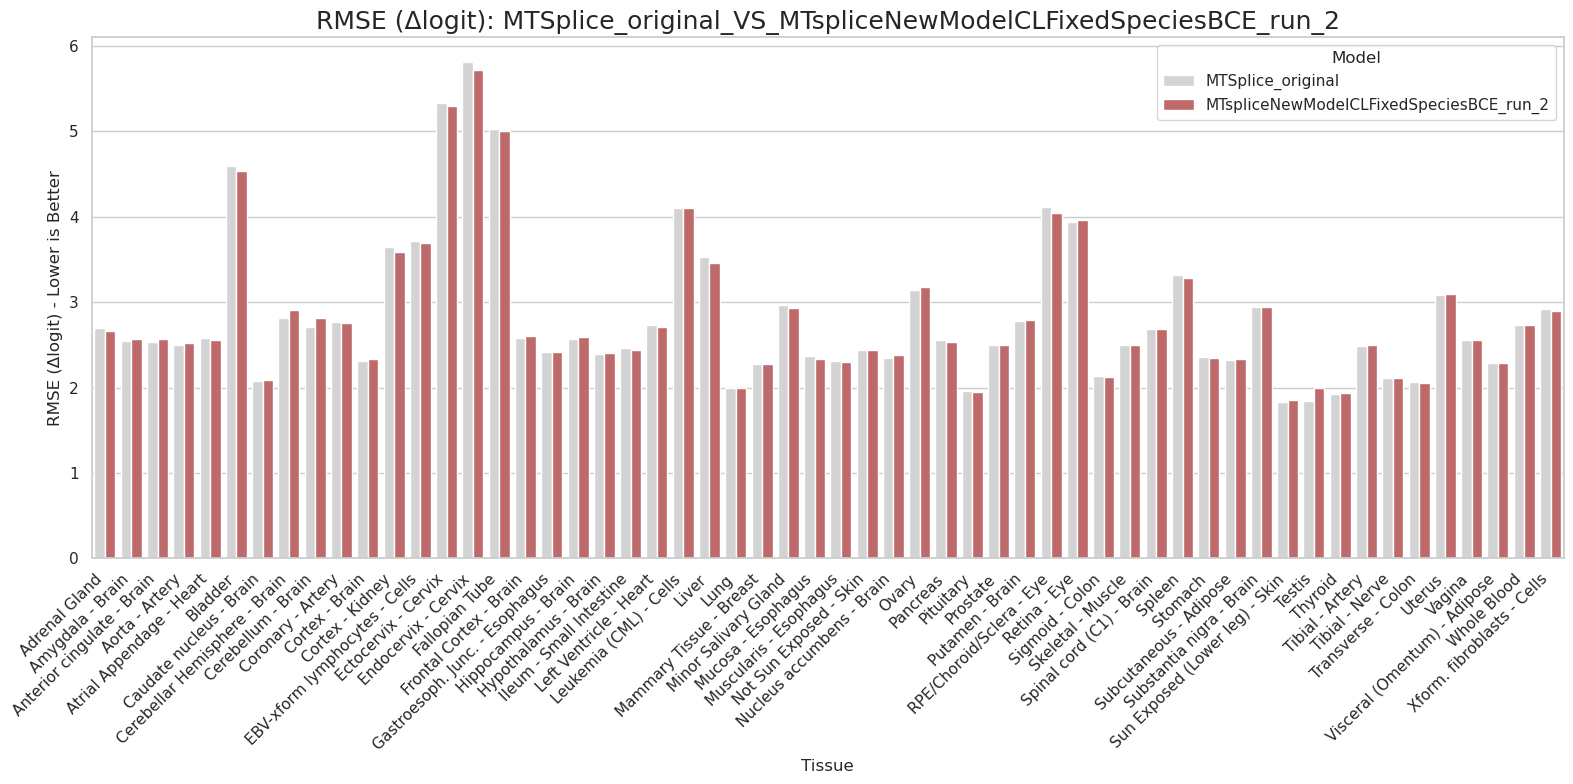

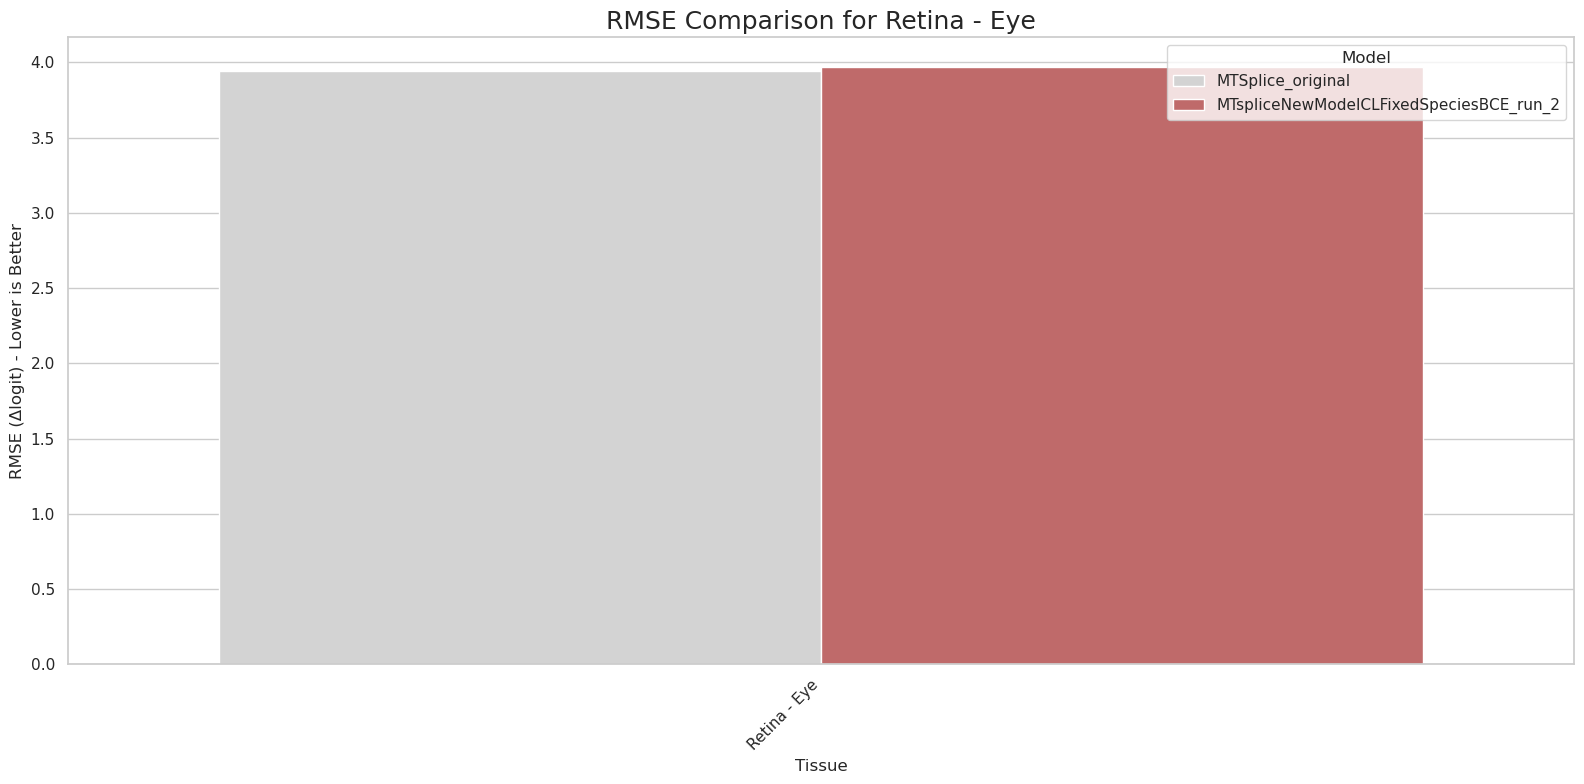

In [ ]:

print(f"\n--- Starting Plot Block 2: {sota_model_name} vs {model3_name} ---")
title = f"{sota_model_name}_VS_{model3_name}"

try:
    # Load and process predictions for Exp 3
    exp3_pred_df, exp3_tissueCols = load_single_run_predictions(EXP3_FOLDER_PATH, exp3_run_name)
    exp3_delta_logit_df, _ = get_delta_psi(exp3_pred_df, exp3_tissueCols, gt_df)
    exp3_delta_logit_df_long = exp3_delta_logit_df.melt(
        id_vars=['exon_id'], value_vars=exp3_tissueCols, var_name='tissue', value_name='pred_delta_logit'
    )
    exp3_rmse = calculate_rmse_by_tissue(exp3_delta_logit_df_long, gt_delta_logit_df_long)
    print(f"Loaded and processed {model3_name}")

    # Prepare data (SOTA vs. Exp 3)
    comp_df_2, melt_df_2 = prepare_grouped_plot_data(
        df1=sota_rmse_df,  # This was loaded at the start
        df2=exp3_rmse,
        metric=metric_name,
        model1_name=sota_model_name,
        model2_name=model3_name
    )

    # Create the plot
    plot_grouped_comparison(
        comp_df_2, melt_df_2,
        title=f'RMSE (Δlogit): {title}',
        model1_name=sota_model_name,
        model2_name=model3_name,
        save_path=f"{fig_maindir}/rmse_delta_logit_{title}{trimester}.png"
    )


    # --- Define the tissue you want to see ---
    # target_tissue = 'Retina - Eye'

    # # --- Filter both DataFrames for that one tissue ---
    # single_tissue_comparison_df = comp_df_2[comp_df_2['tissue'] == target_tissue]
    # single_tissue_melted_df = melt_df_2[melt_df_2['tissue'] == target_tissue]

    # # --- Now, call your plot function with the filtered data ---
    # # --- (This is the fixed part) ---
    # plot_grouped_comparison(
    #     comparison_df=single_tissue_comparison_df, 
    #     melted_df=single_tissue_melted_df, 
    #     title=f"RMSE Comparison for {target_tissue}", 
    #     model1_name=sota_model_name,  # CORRECT: Use the name from this block
    #     model2_name=model3_name   # CORRECT: Use the name from this block
    # )


except FileNotFoundError as e:
    print(f"Error in Plot Block 2: Could not load prediction file. {e}")
except Exception as e:
    print(f"An unexpected error occurred in Plot Block 2: {e}")


--- Generating Delta Logit Histogram for MTspliceNewModelCLFixedSpeciesMSE_run_15 vs Ground Truth (Retina - Eye) ---


Histogram figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/histogram_delta_logit_Retina_Eye_MTspliceNewModelCLFixedSpeciesMSE_run_15_2025_10_23__14_25_43.png


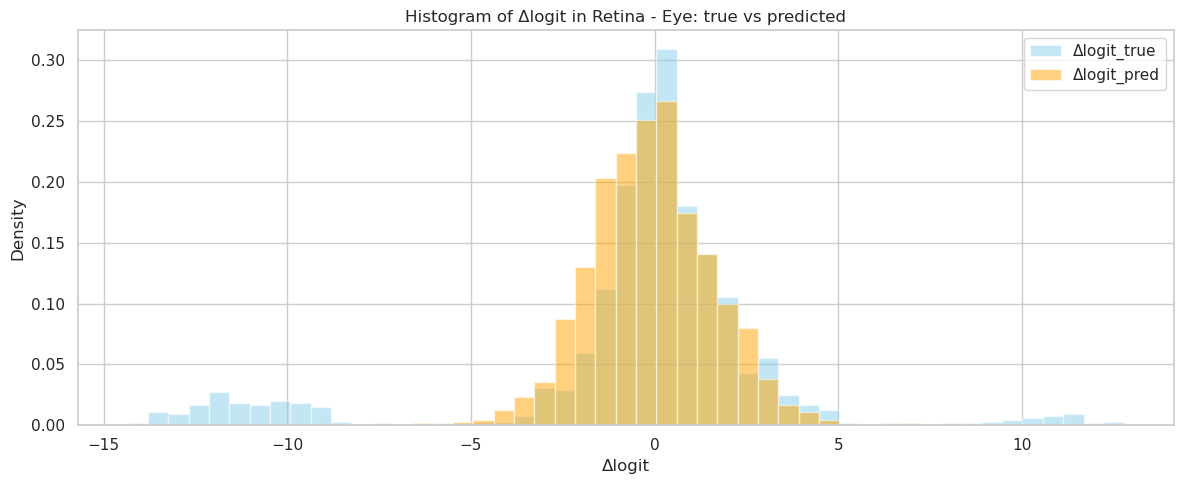

Histogram saved for Retina - Eye.

--- Script Finished ---


In [23]:
# --- ADDED: Histogram Plot for Retina - Eye (Delta Logit) ---
print(f"\n--- Generating Delta Logit Histogram for {model3_name} vs Ground Truth (Retina - Eye) ---")
tissue_to_plot = "Retina - Eye"
value_type_to_plot = "Δlogit" # Specify we are plotting delta logit

# Filter ground truth data for the specific tissue
gt_tissue_data = gt_delta_logit_df_long[gt_delta_logit_df_long['tissue'] == tissue_to_plot]['gt_delta_logit'].dropna()

# Filter prediction data for the specific tissue
pred_tissue_data = exp3_delta_logit_df_long[exp3_delta_logit_df_long['tissue'] == tissue_to_plot]['pred_delta_logit'].dropna()

if gt_tissue_data.empty or pred_tissue_data.empty:
        print(f"Warning: No data found for tissue '{tissue_to_plot}'. Skipping histogram.")
else:
    # Define save path for the histogram
    hist_save_path = f"{fig_maindir}/histogram_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_{model3_name}{trimester}.png"
    
    # Call the plotting function
    plot_histogram(
        y_true=gt_tissue_data,
        y_pred=pred_tissue_data,
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        save_path=hist_save_path
    )
    print(f"Histogram saved for {tissue_to_plot}.")
# --- End of Added Histogram Plot ---

# except FileNotFoundError as e:
# print(f"Error in Plot Block 2: Could not load prediction file. {e}")
# except Exception as e:
# print(f"An unexpected error occurred in Plot Block 2: {e}")


print("\n--- Script Finished ---")


--- Generating Delta Logit Histogram for SOTA vs Ground Truth (Retina - Eye) ---
Histogram figure saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/histogram_delta_logit_Retina_Eye_SOTA_vs_GT_2025_10_23__14_25_43.png


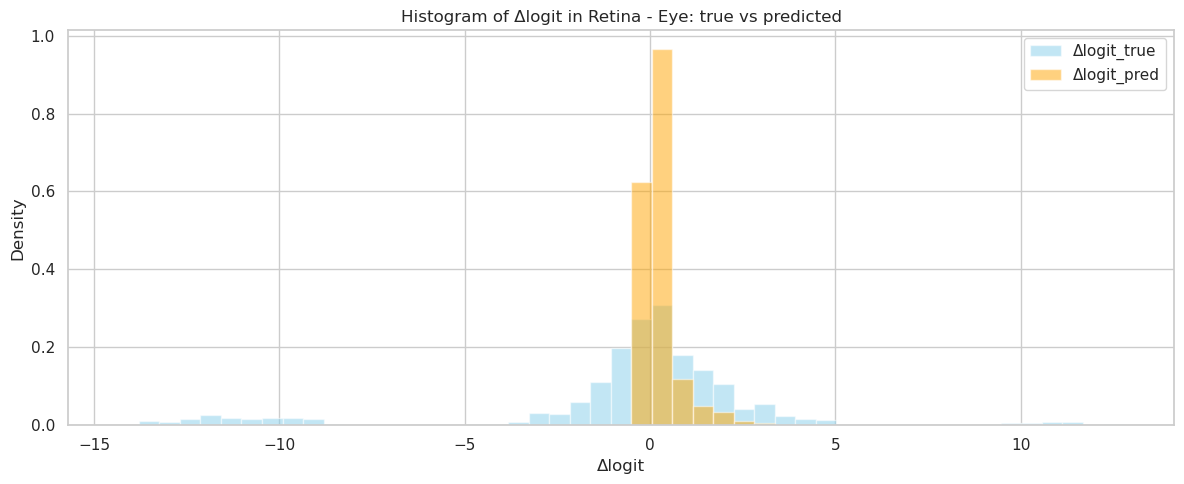

SOTA vs GT Histogram saved for Retina - Eye.


In [21]:
# --- ADDED: Histogram Plot for Retina - Eye (SOTA vs Ground Truth) ---
print(f"\n--- Generating Delta Logit Histogram for SOTA vs Ground Truth (Retina - Eye) ---")
tissue_to_plot = "Retina - Eye"
value_type_to_plot = "Δlogit"

# Filter ground truth data (already loaded as gt_delta_logit_df_long)
gt_tissue_data_sota_comp = gt_delta_logit_df_long[gt_delta_logit_df_long['tissue'] == tissue_to_plot]['gt_delta_logit'].dropna()

# Filter SOTA prediction data (already loaded as sota_preds_df_long)
sota_tissue_data = sota_preds_df_long[sota_preds_df_long['tissue'] == tissue_to_plot]['pred_delta_logit'].dropna()

if gt_tissue_data_sota_comp.empty or sota_tissue_data.empty:
        print(f"Warning: No data found for tissue '{tissue_to_plot}' in SOTA comparison. Skipping histogram.")
else:
    # Define save path for the SOTA histogram
    sota_hist_save_path = f"{fig_maindir}/histogram_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_SOTA_vs_GT{trimester}.png"

    # Call the plotting function
    plot_histogram(
        y_true=gt_tissue_data_sota_comp,
        y_pred=sota_tissue_data, # Use SOTA predictions here
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        save_path=sota_hist_save_path
    )
    print(f"SOTA vs GT Histogram saved for {tissue_to_plot}.")
# --- End of Added SOTA Histogram Plot ---


--- Generating Delta Logit Scatter for SOTA vs Ground Truth (Retina - Eye) ---


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Scatter plot saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/scatter_delta_logit_Retina_Eye_MTSplice_original_2025_10_23__14_25_43.png


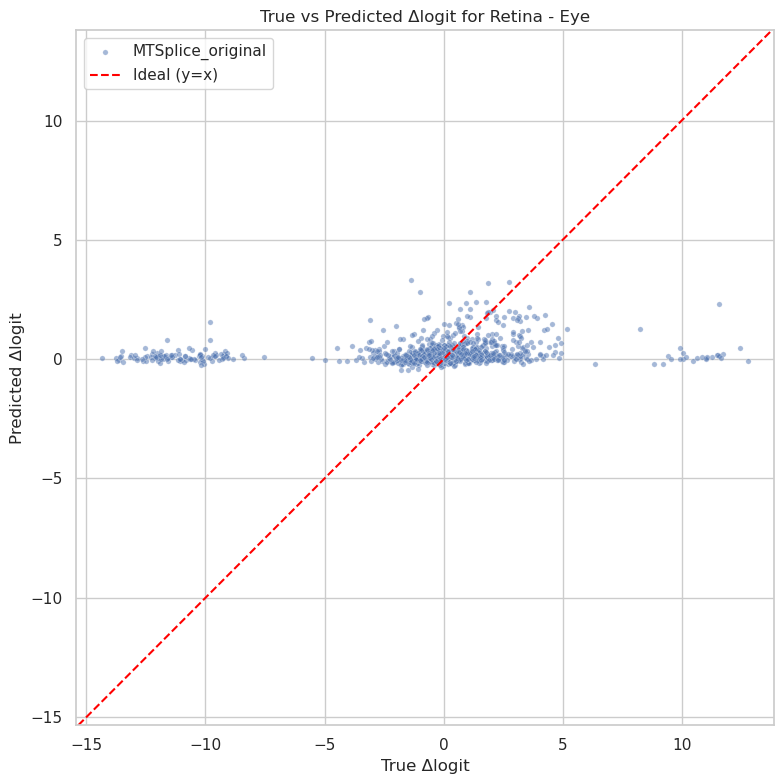


--- Generating Delta Logit Scatter for MTspliceNewModelCLFixedSpeciesMSE_run_15 vs Ground Truth (Retina - Eye) ---


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Scatter plot saved to: /gpfs/commons/home/atalukder/Contrastive_Learning/code/ML_model/figures/scatter_delta_logit_Retina_Eye_MTspliceNewModelCLFixedSpeciesMSE_run_15_2025_10_23__14_25_43.png


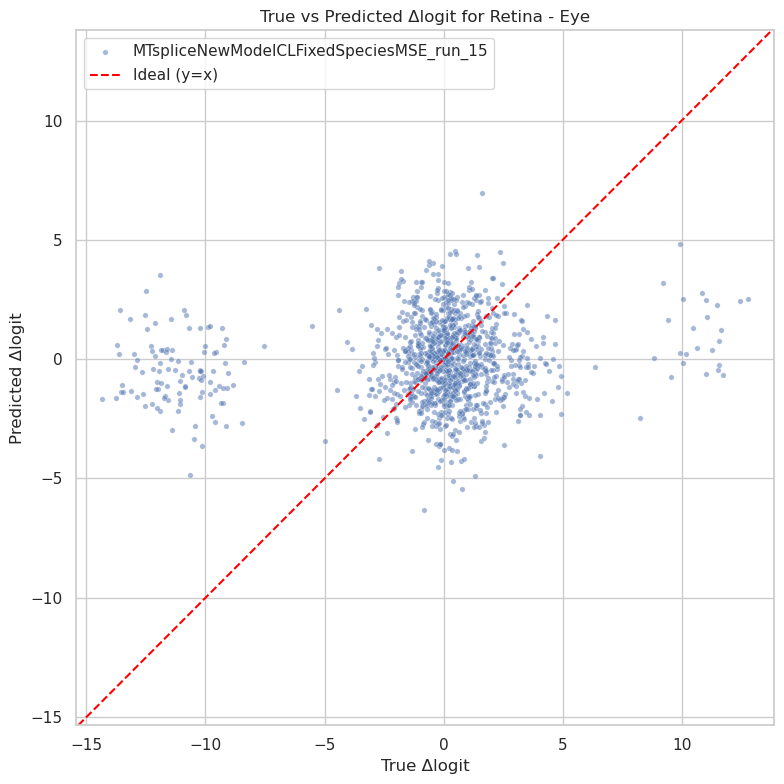

In [25]:
# --- Plot Block 2: SOTA vs User Exp 3 ---
# (After loading sota_rmse_df and exp3_rmse)
# ... (existing RMSE plot code) ...

# --- ADDED: Scatter Plot for Retina - Eye (SOTA vs GT) ---
print(f"\n--- Generating Delta Logit Scatter for SOTA vs Ground Truth (Retina - Eye) ---")
tissue_to_plot = "Retina - Eye"
value_type_to_plot = "Δlogit"

# Filter ground truth data
gt_tissue_data_sota = gt_delta_logit_df_long[gt_delta_logit_df_long['tissue'] == tissue_to_plot]#['gt_delta_logit'].dropna()

# Filter SOTA prediction data
sota_tissue_data = sota_preds_df_long[sota_preds_df_long['tissue'] == tissue_to_plot]#['pred_delta_logit'].dropna()

# Align data on exon_id before plotting
scatter_data_sota = pd.merge(
    gt_tissue_data_sota[['exon_id', 'gt_delta_logit']],
    sota_tissue_data[['exon_id', 'pred_delta_logit']],
    on='exon_id'
).dropna()

if scatter_data_sota.empty:
     print(f"Warning: No overlapping data found for tissue '{tissue_to_plot}' for SOTA. Skipping scatter plot.")
else:
    sota_scatter_save_path = f"{fig_maindir}/scatter_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_{sota_model_name}{trimester}.png"
    plot_scatter_comparison(
        y_true=scatter_data_sota['gt_delta_logit'],
        y_pred=scatter_data_sota['pred_delta_logit'],
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        model_name=sota_model_name, # Pass model name
        save_path=sota_scatter_save_path
    )


# --- ADDED: Scatter Plot for Retina - Eye (Exp 3 vs GT) ---
print(f"\n--- Generating Delta Logit Scatter for {model3_name} vs Ground Truth (Retina - Eye) ---")
# Filter Exp 3 prediction data (GT is the same)
pred_tissue_data_exp3 = exp3_delta_logit_df_long[exp3_delta_logit_df_long['tissue'] == tissue_to_plot]#['pred_delta_logit'].dropna()

# Align data on exon_id before plotting
scatter_data_exp3 = pd.merge(
    gt_tissue_data_sota[['exon_id', 'gt_delta_logit']], # Re-use filtered GT data
    pred_tissue_data_exp3[['exon_id', 'pred_delta_logit']],
    on='exon_id'
).dropna()

if scatter_data_exp3.empty:
     print(f"Warning: No overlapping data found for tissue '{tissue_to_plot}' for Exp 3. Skipping scatter plot.")
else:
    scatter_save_path_exp3 = f"{fig_maindir}/scatter_{value_type_to_plot.replace('Δ','delta_')}_{tissue_to_plot.replace(' - ', '_')}_{model3_name}{trimester}.png"
    plot_scatter_comparison(
        y_true=scatter_data_exp3['gt_delta_logit'],
        y_pred=scatter_data_exp3['pred_delta_logit'],
        tissue=tissue_to_plot,
        value_type=value_type_to_plot,
        model_name=model3_name, # Pass model name
        save_path=scatter_save_path_exp3
    )

# ... (rest of Plot Block 2 error handling and histogram code) ...

In [ ]:
######################################